# MiniProject2: Breaking the Panorama Code

Name: Svita Kiran

Solo or Team Project
Partner: N/A

## Learning Objective

By the end of this project you should be able to:

1. Understand and implement 2D convolution and key filters used in CV.
2. Implement a simple corner detector and descriptor and then match features.
3. Know how [RANSAC homography and a image stitching pipeline](https://visionbook.mit.edu/homography.html) work.
4. How these all can work together to produce a flyer with the stitched panorama.

6 + 6 + 6 + 6 + 2 = 26 pts

## Your work here



*  Start by reading the tasks in order.
*  Pick an existing panorama image or a regular image.

For panorama, [there are lots of images here](https://www.pexels.com/search/panorama/).


* For each task make sure that after your code, the output image appears.

    Try also showing intermediate images whenever you can.


* Write 1-2 lines of note for what you observe.
Even if you fund a solution on the web for completing apartcular short task, you should always ask, **why am I using this approach**?

* For some questions, you will need to do a bit of research on your own.


###Storyline

The campus festival just ended. Someone dumped ~50 unordered photos into a folder — different phones, different exposures, some blurry. some with low light. By sunrise, you, as the president 'Sunrise Photography Club' must deliver a gorgeous flyer with a  panorama and 2-3 nice scene description go with it.

See this [image](https://magazine.colby.edu/issue/vol-112-issue-1/#wilderness) from Colby Magazine for inspiration.



### Environment

In [3]:
# If running in Colab, please uncomment:
!pip -q install opencv-python-headless==4.10.0.84 reportlab==4.2.2 scikit-image==0.24.0
import numpy as np, cv2, math, os, glob
from pathlib import Path
print("OpenCV:", cv2.__version__)


# It is mot mandatory to use these versions


OpenCV: 4.10.0


### Get the data


To get your data you have three options:

1. Slice a large panorama into overlapping tiles.
[there are lots of images here](https://www.pexels.com/search/panorama/).
2. Programmatically generate slices from an image with 30% overlap
3. To make it look like individual images, apply motion blur/noise to make it look messy

In [4]:
image_path = "/ogImage.jpg"
output_dir = "/content/data/fest"
os.makedirs(output_dir, exist_ok=True)

img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError("Image not found at " + image_path)

h, w, _ = img.shape
num_slices = 30
overlap = 0.3

slice_width = int(w / (num_slices - (num_slices - 1) * overlap))
step = int(slice_width * (1 - overlap))

count = 0
for x in range(0, w - slice_width + 1, step):
    if count >= num_slices:
        break
    slice_img = img[:, x:x + slice_width]
    out_path = os.path.join(output_dir, f"img{count:02d}.jpg")
    cv2.imwrite(out_path, slice_img)
    count += 1

print(f"{count} slices saved in {output_dir}")

30 slices saved in /content/data/fest


In this task I loaded the image which was locally stored in Colab into a folder I made which is also in Colab. Then I sliced the panorama into 30 images with a 30% overlap and saved them to the folder.


### Create your data folder

Create a folder like `/content/data/fest` (in Colab) or `./data/fest` (in local) with **30–50 images** of one scene. Aim for ≥30% overlap and mostly rotational motion around one point. Avoid close moving subjects.

Tip: Try your entire pipeline with 6–8 images first before scaling up.



### Task 1: Implement at least 4 filters from `conv2d`,  Gaussian, Sobel X/Y, emboss, etc. (6 pts)

Test on a few **64×64** images and compare to OpenCV numerically.

Tip: You can resize your image for this step.

**Resource**:
1. [How does kernels or filter work](https://setosa.io/ev/image-kernels/)? Visualize here.


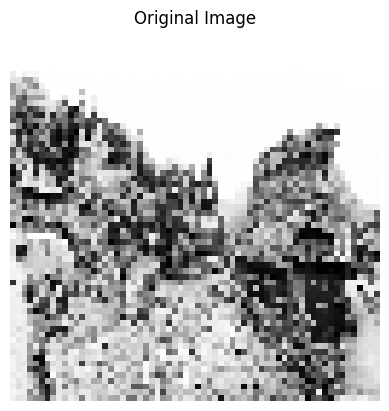

gaussian diff: 0.502593994140625
sobel x diff: 267.842529296875
sobel y diff: 262.615478515625


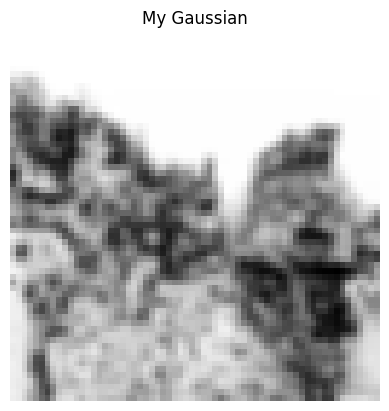

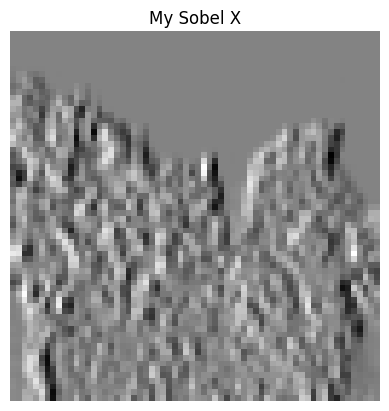

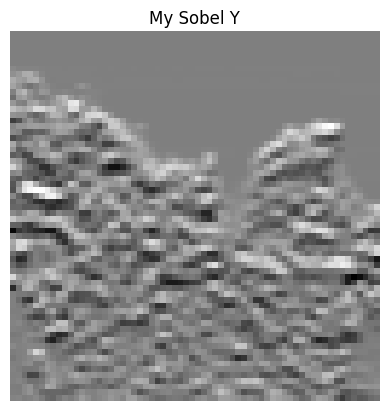

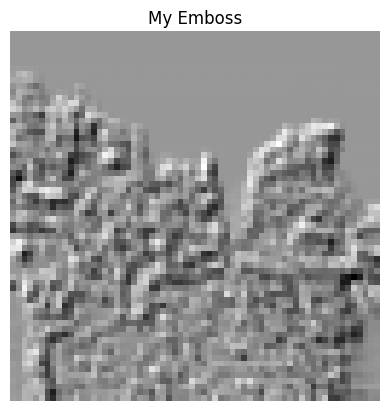

In [5]:
import matplotlib.pyplot as plt

img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (64, 64))

plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

## 2D convolution
from scipy.signal import convolve2d

def conv2d(img, kernel):
    return convolve2d(img, kernel, mode='same', boundary='symm')


## filters
# gaussian blur
gaussian = (1/16) * np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
])

# sobel x
sobel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

# sobel y
sobel_y = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
])

# emboss
emboss = np.array([
    [-2, -1, 0],
    [-1,  1, 1],
    [ 0,  1, 2]
])


## apply filters
my_gaussian = conv2d(img, gaussian)
my_sobelx = conv2d(img, sobel_x)
my_sobely = conv2d(img, sobel_y)
my_emboss = conv2d(img, emboss)

# opencv outputs for comparison
cv_gaussian = cv2.GaussianBlur(img, (3,3), 0)
cv_sobelx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
cv_sobely = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)

# comparing numerically
print("gaussian diff:", np.abs(my_gaussian - cv_gaussian).mean())
print("sobel x diff:", np.abs(my_sobelx - cv_sobelx).mean())
print("sobel y diff:", np.abs(my_sobely - cv_sobely).mean())


filters = {
    "My Gaussian": my_gaussian,
    "My Sobel X": my_sobelx,
    "My Sobel Y": my_sobely,
    "My Emboss": my_emboss
}

for title, result in filters.items():
    plt.imshow(result, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()





In this task I first resized the slice into 64x64 and then passed a filter over the image's matrix for each filter I chose: Gaussian, Sobel X, Sobel Y, and Emboss. OpenCV also has their own outputs for these processes which I inlcuded in the code but aren't shown below.


### Task 2: Apply Harris Corners + Patch Descriptor (6 pts)
1. Compute Harris response on a blurred grayscale image.  
2. Non-max suppression to keep top **N** corners.  
3. For each corner, compute dominant gradient orientation and extract a **15×15** patch, rotate to 0°, normalize (zero-mean, unit-var), downsample to **9×9**, flatten.




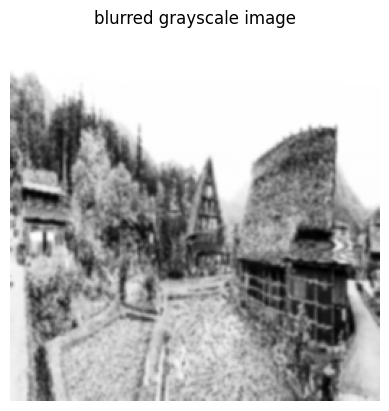

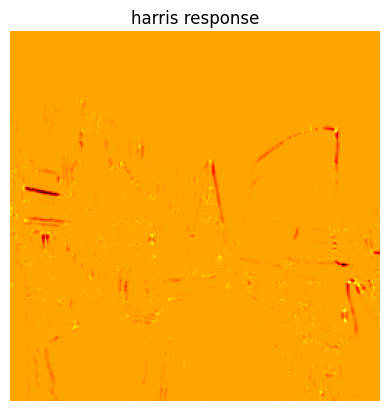

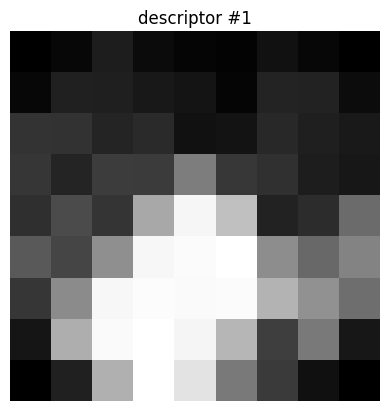

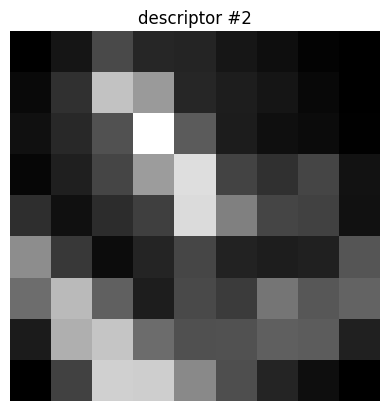

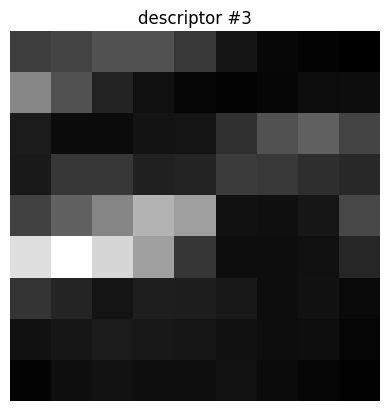

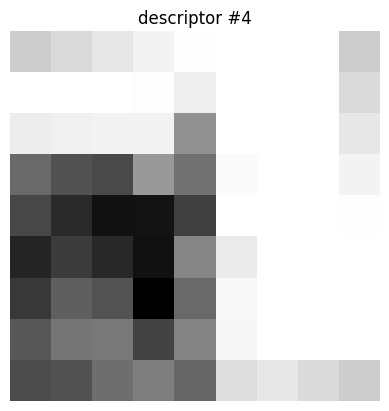

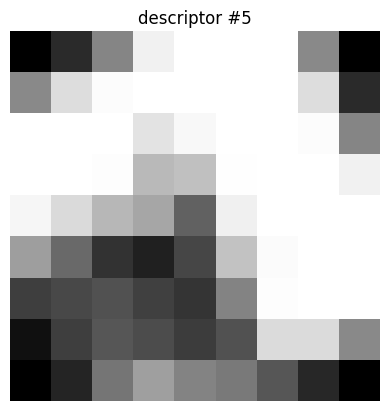

In [6]:
img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
img_gray = cv2.resize(img_gray, (256, 256))  # for testing
img_blur = cv2.GaussianBlur(img_gray, (5, 5), 1)

plt.imshow(img_blur, cmap='gray')
plt.title('blurred grayscale image')
plt.axis('off')
plt.show()

## harris response

block_size = 2
ksize = 3
k = 0.04

img_float = np.float32(img_blur)
harris = cv2.cornerHarris(img_float, block_size, ksize, k)
harris_norm = cv2.normalize(harris, None, 0, 255, cv2.NORM_MINMAX)
plt.imshow(harris_norm, cmap='hot')
plt.title('harris response')
plt.axis('off')
plt.show()


## non max suppression

num_corners = 100
threshold = 0.01 * harris.max()
corners = np.argwhere(harris > threshold)
corner_values = harris[harris > threshold]
sorted_idx = np.argsort(-corner_values)
top_corners = corners[sorted_idx[:num_corners]]

## gradient orientation
grad_x = cv2.Sobel(img_float, cv2.CV_32F, 1, 0, ksize=3)
grad_y = cv2.Sobel(img_float, cv2.CV_32F, 0, 1, ksize=3)
gradient_orientation = np.degrees(np.arctan2(grad_y, grad_x))


## extract & normalize patches

descriptors = []
patch_size = 15
half_patch = patch_size // 2

for y, x in top_corners:
    if y < half_patch or y + half_patch >= img_gray.shape[0] or x < half_patch or x + half_patch >= img_gray.shape[1]:
        continue

    patch = img_gray[y - half_patch: y + half_patch + 1,
                     x - half_patch: x + half_patch + 1]
    angle = gradient_orientation[y, x]

    M = cv2.getRotationMatrix2D((half_patch, half_patch), -angle, 1.0)

    patch_rotated = cv2.warpAffine(patch, M, (patch_size, patch_size), flags=cv2.INTER_LINEAR)
    patch_normalized = (patch_rotated - np.mean(patch_rotated)) / (np.std(patch_rotated) + 1e-5)
    patch_downsampled = cv2.resize(patch_normalized, (9, 9), interpolation=cv2.INTER_AREA)
    descriptor = patch_downsampled.flatten()
    descriptors.append(descriptor)


for i in range(5):
    plt.imshow(descriptors[i].reshape(9, 9), cmap='gray')
    plt.title(f'descriptor #{i+1}')
    plt.axis('off')
    plt.show()



In this task, I computed the Harris corner response on a blurred grayscale image and used non maximum suppression to select the top 100 corners. For each corner, I calculated the gradient orientation, extracted a 15×15 patch around it, rotated the patch to align with 0°, normalized it, downsampled it to 9×9, and flattened it to form the final descriptor.


###Task3: Stitching together an image with RANSAC Homography (6 pts)

We need this step since each image would be taken at a slightly different angle.

**Homography**: Projective – mapping between any two projection
planes with the same center of projection.

**Resource**: [OpenCV Homography](https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html)



homography matrix:
 [[ 9.73952371e-01 -2.31367910e-05 -2.60612702e+02]
 [-5.77464306e-02  9.81145955e-01  1.94823176e+01]
 [-5.35586617e-05 -6.51934329e-07  1.00000000e+00]]


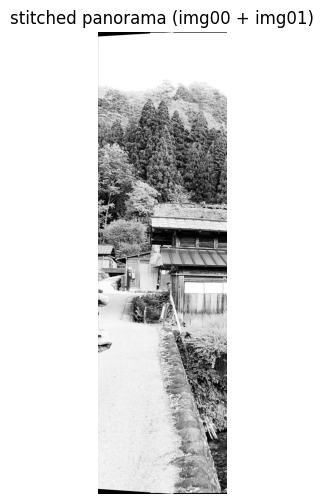

In [7]:
img1 = cv2.imread("/content/data/fest/img00.jpg", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("/content/data/fest/img01.jpg", cv2.IMREAD_GRAYSCALE)

orb = cv2.ORB_create(nfeatures=2000)

kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING)
matches_knn = bf.knnMatch(des1, des2, k=2)

good_matches = []
for m, n in matches_knn:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
print("homography matrix:\n", H)

height2, width2 = img2.shape
height1, width1 = img1.shape

corners_img1 = np.float32([[0,0], [0,height1], [width1, height1], [width1,0]]).reshape(-1,1,2)
warped_corners = cv2.perspectiveTransform(corners_img1, H)
all_corners = np.concatenate((warped_corners, np.float32([[0,0],[0,height2],[width2,height2],[width2,0]]).reshape(-1,1,2)), axis=0)

[xmin, ymin] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
[xmax, ymax] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

translation = np.array([[1, 0, -xmin],
                        [0, 1, -ymin],
                        [0, 0, 1]])

panorama = cv2.warpPerspective(img1, translation @ H, (xmax - xmin, ymax - ymin))
panorama[-ymin:height2 - ymin, -xmin:width2 - xmin] = img2

plt.figure(figsize=(12, 6))
plt.imshow(panorama, cmap='gray')
plt.title("stitched panorama (img00 + img01)")
plt.axis('off')
plt.show()







In this task, I used ORB features to detect and match keypoints between two overlapping images. Then I applied RANSAC to estimate the homography matrix that maps one image’s points to another image. With that I warped one image and stitched it together with the second to create a panorama.

### Task4: Create a panorama (6 pts)

Use Tasks1-3 functions to perform this step where you load the images from the data folder


Here you are welcome to take as many steps as possible. Use any functions we have discussed in this notebook or lecture or anything that you can come up with.


The goal is to get the best possible panorama.




stitching block 1/6
  stitching img00 + img01 (block)
skip: homography could not be computed
  stitching img01 + img02 (block)
skip: not enough matches
  stitching img02 + img03 (block)
  stitching img03 + img04 (block)
skip: not enough matches
stitching block 2/6
  stitching img00 + img01 (block)
skip: not enough matches
  stitching img01 + img02 (block)
  stitching img02 + img03 (block)
  stitching img03 + img04 (block)
stitching block 3/6
  stitching img00 + img01 (block)
  stitching img01 + img02 (block)
  stitching img02 + img03 (block)
  stitching img03 + img04 (block)
stitching block 4/6
  stitching img00 + img01 (block)
  stitching img01 + img02 (block)
  stitching img02 + img03 (block)
  stitching img03 + img04 (block)
skip: not enough matches
stitching block 5/6
  stitching img00 + img01 (block)
  stitching img01 + img02 (block)
  stitching img02 + img03 (block)
skip: homography could not be computed
  stitching img03 + img04 (block)
skip: not enough matches
stitching block 6

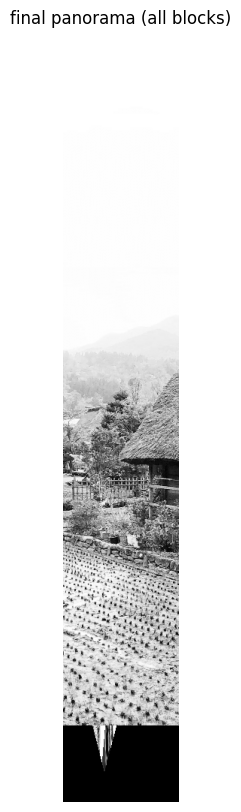

In [8]:
from glob import glob

def load_images(folder, scale=0.4):
    paths = sorted(glob(os.path.join(folder, "img*.jpg")))
    images = []
    for path in paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if scale < 1.0:
            img = cv2.resize(img, (0, 0), fx=scale, fy=scale)
        images.append(img)
    return images

def stitch_pair(img1, img2):
    orb = cv2.ORB_create(nfeatures=2000)
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches_knn = bf.knnMatch(des1, des2, k=2)

    good_matches = [m for m, n in matches_knn if m.distance < 0.75 * n.distance]
    if len(good_matches) < 4:
        print("skip: not enough matches")
        return img1

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    if H is None:
        print("skip: homography could not be computed")
        return img1

    h1, w1 = img1.shape
    h2, w2 = img2.shape

    corners_img1 = np.float32([[0,0], [0,h1], [w1,h1], [w1,0]]).reshape(-1,1,2)
    corners_img1_warped = cv2.perspectiveTransform(corners_img1, H)

    corners_img2 = np.float32([[0,0], [0,h2], [w2,h2], [w2,0]]).reshape(-1,1,2)
    all_corners = np.concatenate((corners_img1_warped, corners_img2), axis=0)

    [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    translation = np.array([[1, 0, -xmin],
                            [0, 1, -ymin],
                            [0, 0, 1]])

    result = cv2.warpPerspective(img1, translation @ H, (xmax - xmin, ymax - ymin))
    result[-ymin:h2 - ymin, -xmin:w2 - xmin] = img2
    return result

def stitch_block(images):
    panorama = images[0]
    for i in range(1, len(images)):
        print(f"  stitching img{i-1:02d} + img{i:02d} (block)")
        panorama = stitch_pair(panorama, images[i])
    return panorama

images = load_images("/content/data/fest", scale=0.4)

block_size = 5
blocks = [images[i:i + block_size] for i in range(0, len(images), block_size)]
stitched_blocks = []
for i, block in enumerate(blocks):
    print(f"stitching block {i + 1}/{len(blocks)}")
    stitched = stitch_block(block)
    stitched_blocks.append(stitched)

print("stitching all blocks together...")
final_panorama = stitched_blocks[0]
for i in range(1, len(stitched_blocks)):
    print(f"final merge: block {i - 1} + block {i}")
    final_panorama = stitch_pair(final_panorama, stitched_blocks[i])

plt.figure(figsize=(20, 10))
plt.imshow(final_panorama, cmap='gray')
plt.title("final panorama (all blocks)")
plt.axis('off')
plt.show()




This task was difficult because the runtime got overwhelmed as the computational power needed exceeded the amount available in the RAM. This caused the entire program to fail and I would have to restart again. I was able to fix this problem by skipping blocks without enough matches, however, this ended up making a panorama that missed many details and slides from the original panorama.


### Task5: Make the Flyer
Place the panorama and add the text Have fun. Get creative.


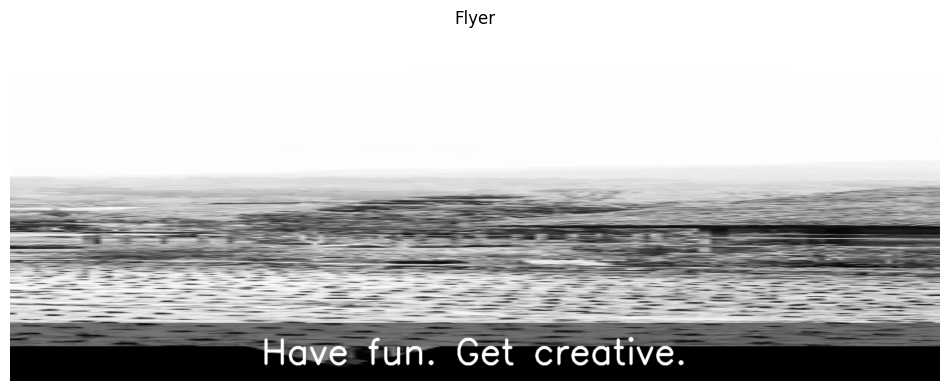

In [9]:
def make_flyer(panorama, output_path="flyer.jpg"):
    if len(panorama.shape) == 2:
        flyer = cv2.cvtColor(panorama, cv2.COLOR_GRAY2BGR)
    else:
        flyer = panorama.copy()

    flyer = cv2.resize(flyer, (1600, 600))

    overlay = flyer.copy()
    cv2.rectangle(overlay, (0, 500), (1600, 600), (0, 0, 0), -1)
    flyer = cv2.addWeighted(overlay, 0.5, flyer, 0.5, 0)

    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Have fun. Get creative."
    text_size = cv2.getTextSize(text, font, 2, 3)[0]
    text_x = (flyer.shape[1] - text_size[0]) // 2
    text_y = 570
    cv2.putText(flyer, text, (text_x, text_y), font, 2, (255, 255, 255), 3, cv2.LINE_AA)

    cv2.imwrite(output_path, flyer)
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(flyer, cv2.COLOR_BGR2RGB))
    plt.title("Flyer")
    plt.axis('off')
    plt.show()

make_flyer(final_panorama)









I was able to do this by resizing the panorama from where it was previously stitched together and then add a text overlay to it at the bottom.


## Extensions


You can pick you own topics that interest you for extra credits. Here are a few examples:

1. Can you present this rectangualr panorama into a spherical shape?

3. Can you use this whole pipeline, but this time instead of one image your source will be two image of the same object. The goal is to create a panorama again.

2x3 = 6 pts (doing 2 extensions will get you 6 points)


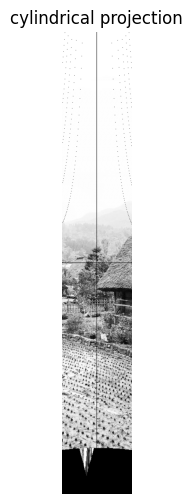

In [10]:
def cylindrical_projection(img, focal_length):
    h, w = img.shape[:2]
    cyl = np.zeros_like(img)

    center_x = w // 2
    center_y = h // 2

    for y in range(h):
        for x in range(w):
            theta = (x - center_x) / focal_length
            h_ = (y - center_y) / focal_length

            X = math.sin(theta)
            Y = h_
            Z = math.cos(theta)

            x_proj = int(focal_length * X / Z + center_x)
            y_proj = int(focal_length * Y / Z + center_y)

            if 0 <= x_proj < w and 0 <= y_proj < h:
                cyl[y_proj, x_proj] = img[y, x]

    return cyl

focal_length = 500
cylindrical = cylindrical_projection(final_panorama, focal_length)

plt.figure(figsize=(16, 6))
plt.imshow(cylindrical, cmap='gray')
plt.title("cylindrical projection")
plt.axis('off')
plt.show()









In this extension, I projected the rectangular panorama onto a cylindrical surface using a custom cylindrical projection function. This warping helps simulate how panoramic images are captured in real life, wrapping the flat image around a curved surface to reduce distortion, especially at the edges. This technique is useful for creating more realistic panoramic views and is used in 360 degree photography and virtual reality environments.


## Where to get images (according to GPT-5)
- **Your own capture (best):** one scene, ≥30% overlap, rotate around one point, lock exposure if you can.
- **Open datasets / free sources:**  
  - Oxford **Affine** dataset (6-image homography sequences per scene): https://opendatalab.com/OpenDataLab/Oxford-Affine/download  
  - Hugin sample sets & multi-row tutorial: https://hugin.sourceforge.io/tutorials/multi-row/ and example files: https://www.dkloi.co.uk/?p=1490
  - Wikimedia Commons panoramas (CC): https://commons.wikimedia.org/wiki/Category:Panoramas  
  - Unsplash (free): https://unsplash.com/s/photos/panoramic , https://unsplash.com/s/photos/city-panorama  
  - Pexels (free): https://www.pexels.com/search/panorama/ , https://www.pexels.com/search/city%20panorama/  
  - PIXLS.us Hugin tutorial with sample **zip**: https://pixls.us/articles/aligning-images-with-hugin/  
  



## Acknowledgements

To Robert, for all the bagels. (replace with your own Acknowledgements)








## Checklist

1. Submit the completed notebook with all output images embedded and your answers (no need for submitting the images you use in case they are large in size)

2. Submit a short video (3~5 minutes) talking through what you have done and observed.


3. I look forward to seeing your extensions!


### Resources

[Image kernels at Play](https://setosa.io/ev/image-kernels/)

[Computer vision: Algorithms and Applications By Richard Szelisk](https://szeliski.org/Book/drafts/SzeliskiBook_20100903_draft.pdf)

[Foundations of Computer Viison](https://visionbook.mit.edu/)